### requirements for the following codings


In [5]:
### packages required 
# !pip install fair-esm 
# !pip install torch
# !pip install tensorflow
# !pip install sklearn

### peptide embeddings with esm2_t6_8M_UR50D pretrained models
6 layers, 8M parameters, dataset: UR50/D 2021_04, embedding dimension: 320
mode download URL: https://dl.fbaipublicfiles.com/fair-esm/models/esm2_t6_8M_UR50D.pt

In [6]:
def esm_embeddings(peptide_sequence_list):
  # NOTICE: ESM for embeddings is quite RAM usage, if your sequence is too long, 
  #         or you have too many sequences for transformation in a single converting, 
  #         you conputer might automatically kill the job.
  import torch
  import esm
  import collections
  # load the model
  # NOTICE: if the model was not downloaded in your local environment, it will automatically download it.
  model, alphabet = esm.pretrained.esm2_t6_8M_UR50D()
  batch_converter = alphabet.get_batch_converter()
  model.eval()  # disables dropout for deterministic results

  # load the peptide sequence list into the bach_converter
  batch_labels, batch_strs, batch_tokens = batch_converter(peptide_sequence_list)
  batch_lens = (batch_tokens != alphabet.padding_idx).sum(1)
  ## batch tokens are the embedding results of the whole data set

  # Extract per-residue representations (on CPU)
  with torch.no_grad():
      # Here we export the last layer of the EMS model output as the representation of the peptides
      # model'esm2_t6_8M_UR50D' only has 6 layers, and therefore repr_layers parameters is equal to 6
      results = model(batch_tokens, repr_layers=[6], return_contacts=True)  
  token_representations = results["representations"][6]

  # Generate per-sequence representations via averaging
  # NOTE: token 0 is always a beginning-of-sequence token, so the first residue is token 1.
  sequence_representations = []
  for i, tokens_len in enumerate(batch_lens):
      sequence_representations.append(token_representations[i, 1 : tokens_len - 1].mean(0))
  # save dataset
  # sequence_representations is a list and each element is a tensor
  embeddings_results = collections.defaultdict(list)
  for i in range(len(sequence_representations)):
      # tensor can be transformed as numpy sequence_representations[0].numpy() or sequence_representations[0].to_list
      each_seq_rep = sequence_representations[i].tolist()
      for each_element in each_seq_rep:
          embeddings_results[i].append(each_element)
  embeddings_results = pd.DataFrame(embeddings_results).T
  return embeddings_results

### data loading and embeddings

In [7]:
import numpy as np
import pandas as pd

In [8]:
# training dataset loading
dataset = pd.read_excel('APP_train.xlsx',na_filter = False) # take care the NA sequence problem
sequence_list = dataset['sequence'] 

embeddings_results = pd.DataFrame()
for seq in sequence_list:
    format_seq = [seq,seq] # the setting is just following the input format setting in ESM model, [name,sequence]
    tuple_sequence = tuple(format_seq)
    peptide_sequence_list = []
    peptide_sequence_list.append(tuple_sequence) # build a summarize list variable including all the sequence information
    # employ ESM model for converting and save the converted data in csv format
    one_seq_embeddings = esm_embeddings(peptide_sequence_list)
    embeddings_results= pd.concat([embeddings_results,one_seq_embeddings])

embeddings_results.to_csv('APP_train_esm2_t6_8M_UR50D_unified_320_dimension.csv')

# loading the y dataset for model development 
y_train = dataset['label']
y_train = np.array(y_train) # transformed as np.array for CNN model

In [10]:
y_train

array([0, 0, 0, ..., 1, 1, 1], dtype=int64)

In [11]:
# test dataset loading
dataset = pd.read_excel('APP_test.xlsx',na_filter = False) # take care the NA sequence problem
sequence_list = dataset['sequence'] 
embeddings_results = pd.DataFrame()
# embedding all the peptide one by one
for seq in sequence_list:
    format_seq = [seq,seq] # the setting is just following the input format setting in ESM model, [name,sequence]
    tuple_sequence = tuple(format_seq)
    peptide_sequence_list = []
    peptide_sequence_list.append(tuple_sequence) # build a summarize list variable including all the sequence information
    # employ ESM model for converting and save the converted data in csv format
    one_seq_embeddings = esm_embeddings(peptide_sequence_list)
    embeddings_results= pd.concat([embeddings_results,one_seq_embeddings])

embeddings_results.to_csv('APP_test_esm2_t6_8M_UR50D_unified_320_dimension.csv')


# loading the y dataset for model development 
y_test = dataset['label']
y_test = np.array(y_test) # transformed as np.array for CNN model

In [12]:
# assign the dataset 
X_train_data_name = 'APP_train_esm2_t6_8M_UR50D_unified_320_dimension.csv'
X_train_data = pd.read_csv(X_train_data_name,header=0, index_col = 0,delimiter=',')

X_test_data_name = 'APP_test_esm2_t6_8M_UR50D_unified_320_dimension.csv'
X_test_data = pd.read_csv(X_test_data_name,header=0, index_col = 0,delimiter=',')

X_train = np.array(X_train_data)
X_test = np.array(X_test_data)

# normalize the X data range
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train) # normalize X to 0-1 range 
X_test = scaler.transform(X_test)

In [13]:
# check the dimension of the dataset before model development
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(2118, 320)
(92, 320)
(2118,)
(92,)


In [9]:
# training dataset loading
dataset = pd.read_excel('APP_train.xlsx',na_filter = False) # take care the NA sequence problem
sequence_list = dataset['sequence'] 

# loading the y dataset for model development 
y_train = dataset['label']
y_train = np.array(y_train) # transformed as np.array for CNN model
# test dataset loading
dataset = pd.read_excel('APP_test.xlsx',na_filter = False) # take care the NA sequence problem
sequence_list = dataset['sequence'] 
# loading the y dataset for model development 
y_test = dataset['label']
y_test = np.array(y_test) # transformed as np.array for CNN model
# assign the dataset 
X_train_data_name = 'APP_train_esm2_t6_8M_UR50D_unified_320_dimension.csv'
X_train_data = pd.read_csv(X_train_data_name,header=0, index_col = 0,delimiter=',')

X_test_data_name = 'APP_test_esm2_t6_8M_UR50D_unified_320_dimension.csv'
X_test_data = pd.read_csv(X_test_data_name,header=0, index_col = 0,delimiter=',')

X_train = np.array(X_train_data)
X_test = np.array(X_test_data)

# normalize the X data range
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train) # normalize X to 0-1 range 
X_test = scaler.transform(X_test)
# check the dimension of the dataset before model development
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(2118, 320)
(92, 320)
(2118,)
(92,)


### dataset undersampling

NearMiss-1 selects examples from the majority class that have the smallest average distance to the three closest examples from the minority class. NearMiss-2 selects examples from the majority class that have the smallest average distance to the three furthest examples from the minority class. NearMiss-3 involves selecting a given number of majority class examples for each example in the minority class that are closest.

#### NearMiss

In [10]:
# !pip install imbalanced-learn

In [11]:
# NearMiss-1
from imblearn.under_sampling import NearMiss
# define the undersampling method
undersample = NearMiss(sampling_strategy= 1, version=1, n_neighbors=3)
# transform the dataset
X_train, y_train = undersample.fit_resample(X_train, y_train)

In [12]:
# NearMiss-2
from imblearn.under_sampling import NearMiss
# define the undersampling method
undersample = NearMiss(sampling_strategy= 1, version=2, n_neighbors=3)
# transform the dataset
X_train, y_train = undersample.fit_resample(X_train, y_train)

In [13]:
# NearMiss-3
from imblearn.under_sampling import NearMiss
# define the undersampling method
undersample = NearMiss(sampling_strategy= 1, version=3, n_neighbors=3)
# transform the dataset
X_train, y_train = undersample.fit_resample(X_train, y_train)

c:\users\harel\pycharmprojects\unidl4biopep-auto\venv\lib\site-packages\imblearn\under_sampling\_prototype_selection\_nearmiss.py:203: UserWarning: The number of the samples to be selected is larger than the number of samples available. The balancing ratio cannot be ensure and all samples will be returned.
  warnings.warn(


In [14]:
# check the dimension of the dataset before model development
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(2118, 320)
(92, 320)
(2118,)
(92,)


#### Random select

In [15]:
from imblearn.over_sampling import RandomOverSampler
# define oversampling strategy
oversample = RandomOverSampler(sampling_strategy=1,random_state = 0)
X_train, y_train = oversample.fit_resample(X_train, y_train)

In [16]:
from imblearn.under_sampling import RandomUnderSampler
# define undersampling strategy
undersample = RandomUnderSampler(sampling_strategy='majority',random_state = 1)
X_train, y_train = undersample.fit_resample(X_train, y_train)

In [17]:
# check the dimension of the dataset before model development
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)
print(np.count_nonzero(y_train == 0))
print(np.count_nonzero(y_train == 1))

(3726, 320)
(92, 320)
(3726,)
(92,)
1863
1863


#### Cluster Centroid

In [18]:
from imblearn.under_sampling import ClusterCentroids
# define ClusterCentroids strategy
CC = ClusterCentroids(sampling_strategy=1, random_state = 3)
X_train, y_train = CC.fit_resample(X_train, y_train)

c:\users\harel\pycharmprojects\unidl4biopep-auto\venv\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [19]:
# check the dimension of the dataset before model development
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)
print(np.count_nonzero(y_train == 0))
print(np.count_nonzero(y_train == 1))

(3726, 320)
(92, 320)
(3726,)
(92,)
1863
1863


### Model architecture

In [20]:
def ESM_CNN(X_train, y_train, X_test, y_test):
  from keras.layers import Input,InputLayer, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D,Conv1D
  from keras.layers import AveragePooling2D, MaxPooling2D, Dropout, AveragePooling1D, MaxPooling1D
  from keras.models import Sequential,Model
  from keras.optimizers import SGD
  from keras.callbacks import ModelCheckpoint,LearningRateScheduler, EarlyStopping
  import keras
  from keras import backend as K
  inputShape=(320,1)
  input = Input(inputShape)
  x = Conv1D(128,(3),strides = (1),name='layer_conv1',padding='same')(input)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = MaxPooling1D((2), name='MaxPool1',padding="same")(x)
  x = Dropout(0.15)(x)
  x = Conv1D(32,(3),strides = (1),name='layer_conv2',padding='same')(input)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = MaxPooling1D((2), name='MaxPool2',padding="same")(x)
  x = Dropout(0.15)(x)
  x = Flatten()(x)
  x = Dense(64,activation = 'relu',name='fc1')(x)
  x = Dropout(0.15)(x)
  x = Dense(2,activation = 'softmax',name='fc2')(x)
  model = Model(inputs = input,outputs = x,name='Predict')
  # define SGD optimizer
  momentum = 0.5
  sgd = SGD(lr=0.01, momentum=momentum, decay=0.0, nesterov=False)
  # compile the model
  model.compile(loss='sparse_categorical_crossentropy',optimizer=sgd, metrics=['accuracy'])
  # learning deccay setting
  import math
  def step_decay(epoch): # gradually decrease the learning rate 
      initial_lrate=0.1
      drop=0.6
      epochs_drop = 3.0
      lrate= initial_lrate * math.pow(drop,    # math.pow base raised to a power
            math.floor((1+epoch)/epochs_drop)) # math.floor Round numbers down to the nearest integer
      return lrate
  lrate = LearningRateScheduler(step_decay)

  # early stop setting
  early_stop = EarlyStopping(monitor='val_accuracy', patience = 40,restore_best_weights = True)

  # summary the callbacks_list
  callbacks_list = [ lrate , early_stop]

  model_history = model.fit(X_train, y_train, validation_data=(X_test, y_test),
                            epochs=200,callbacks=callbacks_list,batch_size = 8, verbose=2)
  return model, model_history

### 10-fold cross validation

In [ ]:
#Implementing 10-fold cross validation
from sklearn.model_selection import KFold
k = 10 
kf = KFold(n_splits=k, shuffle = True, random_state=1)
X_train = pd.DataFrame(X_train)
y_train = pd.DataFrame(y_train)

# result collection list
ACC_collecton = []
BACC_collecton = []
Sn_collecton = []
Sp_collecton = []
MCC_collecton = []
AUC_collecton = []

for train_index , test_index in kf.split(y_train):
    X_train_CV , X_valid_CV = X_train.iloc[train_index,:],X_train.iloc[test_index,:]
    y_train_CV , y_valid_CV = y_train.iloc[train_index] , y_train.iloc[test_index]
    model, model_history = ESM_CNN(X_train_CV, y_train_CV, X_valid_CV, y_valid_CV)
    # confusion matrix 
    predicted_class= []
    predicted_protability = model.predict(X_valid_CV,batch_size=1)
    for i in range(predicted_protability.shape[0]):
      index = np.where(predicted_protability[i] == np.amax(predicted_protability[i]))[0][0]
      predicted_class.append(index)
    predicted_class = np.array(predicted_class)
    y_true = y_valid_CV    
    from sklearn.metrics import confusion_matrix
    import math
    # np.ravel() return a flatten 1D array
    TP, FP, FN, TN = confusion_matrix(y_true, predicted_class).ravel() # shape [ [True-Positive, False-positive], [False-negative, True-negative] ]
    ACC = (TP+TN)/(TP+TN+FP+FN)
    ACC_collecton.append(ACC)
    Sn_collecton.append(TP/(TP+FN))
    Sp_collecton.append(TN/(TN+FP))
    MCC = (TP*TN-FP*FN)/math.pow(((TP+FP)*(TP+FN)*(TN+FP)*(TN+FN)),0.5)
    MCC_collecton.append(MCC)
    BACC_collecton.append(0.5*TP/(TP+FN)+0.5*TN/(TN+FP))
    from sklearn.metrics import roc_auc_score
    AUC = roc_auc_score(y_valid_CV, predicted_protability[:,1])
    AUC_collecton.append(AUC)


c:\users\harel\pycharmprojects\unidl4biopep-auto\venv\lib\site-packages\keras\optimizers\legacy\gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/200
420/420 - 9s - loss: 0.5490 - accuracy: 0.8312 - val_loss: 0.3102 - val_accuracy: 0.8633 - lr: 0.1000 - 9s/epoch - 23ms/step
Epoch 2/200
420/420 - 6s - loss: 0.2779 - accuracy: 0.8798 - val_loss: 0.4003 - val_accuracy: 0.7962 - lr: 0.1000 - 6s/epoch - 15ms/step
Epoch 3/200
420/420 - 6s - loss: 0.2181 - accuracy: 0.9102 - val_loss: 0.2023 - val_accuracy: 0.9088 - lr: 0.0600 - 6s/epoch - 15ms/step
Epoch 4/200
420/420 - 6s - loss: 0.1831 - accuracy: 0.9237 - val_loss: 0.1804 - val_accuracy: 0.9169 - lr: 0.0600 - 6s/epoch - 15ms/step
Epoch 5/200
420/420 - 6s - loss: 0.1602 - accuracy: 0.9323 - val_loss: 0.1509 - val_accuracy: 0.9357 - lr: 0.0600 - 6s/epoch - 15ms/step
Epoch 6/200
420/420 - 6s - loss: 0.1160 - accuracy: 0.9559 - val_loss: 0.1025 - val_accuracy: 0.9678 - lr: 0.0360 - 6s/epoch - 15ms/step
Epoch 7/200
420/420 - 6s - loss: 0.0997 - accuracy: 0.9615 - val_loss: 0.0903 - val_accuracy: 0.9464 - lr: 0.0360 - 6s/epoch - 15ms/step
Epoch 8/200
420/420 - 6s - loss: 0.0790 -

c:\users\harel\pycharmprojects\unidl4biopep-auto\venv\lib\site-packages\keras\optimizers\legacy\gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/200
420/420 - 10s - loss: 0.6520 - accuracy: 0.8208 - val_loss: 0.2844 - val_accuracy: 0.8767 - lr: 0.1000 - 10s/epoch - 23ms/step
Epoch 2/200
420/420 - 6s - loss: 0.2933 - accuracy: 0.8741 - val_loss: 0.3569 - val_accuracy: 0.7962 - lr: 0.1000 - 6s/epoch - 15ms/step
Epoch 3/200
420/420 - 6s - loss: 0.2430 - accuracy: 0.8959 - val_loss: 0.2373 - val_accuracy: 0.9196 - lr: 0.0600 - 6s/epoch - 15ms/step
Epoch 4/200
420/420 - 8s - loss: 0.2102 - accuracy: 0.9138 - val_loss: 0.2240 - val_accuracy: 0.9088 - lr: 0.0600 - 8s/epoch - 20ms/step
Epoch 5/200
420/420 - 5s - loss: 0.1840 - accuracy: 0.9260 - val_loss: 0.1927 - val_accuracy: 0.9196 - lr: 0.0600 - 5s/epoch - 13ms/step
Epoch 6/200
420/420 - 6s - loss: 0.1456 - accuracy: 0.9415 - val_loss: 0.1653 - val_accuracy: 0.9357 - lr: 0.0360 - 6s/epoch - 15ms/step
Epoch 7/200
420/420 - 4s - loss: 0.1262 - accuracy: 0.9499 - val_loss: 0.1733 - val_accuracy: 0.9383 - lr: 0.0360 - 4s/epoch - 10ms/step
Epoch 8/200


In [ ]:
from statistics import mean, stdev
print(mean(ACC_collecton),'±',stdev(ACC_collecton))
print(mean(BACC_collecton),'±',stdev(BACC_collecton))
print(mean(Sn_collecton),'±',stdev(Sn_collecton))
print(mean(Sp_collecton),'±',stdev(Sp_collecton))
print(mean(MCC_collecton),'±',stdev(MCC_collecton))
print(mean(AUC_collecton),'±',stdev(AUC_collecton))


In [ ]:
ACC_collecton

### model evaluation in test dataset

In [130]:
# result collection list
ACC_collecton = []
BACC_collecton = []
Sn_collecton = []
Sp_collecton = []
MCC_collecton = []
AUC_collecton = []
model, model_history = ESM_CNN(X_train, y_train, X_test , y_test)
# confusion matrix 
predicted_class= []
predicted_protability = model.predict(X_test,batch_size=1)
for i in range(predicted_protability.shape[0]):
  index = np.where(predicted_protability[i] == np.amax(predicted_protability[i]))[0][0]
  predicted_class.append(index)
predicted_class = np.array(predicted_class)
y_true = y_test    
from sklearn.metrics import confusion_matrix
import math
# np.ravel() return a flatten 1D array
TP, FP, FN, TN = confusion_matrix(y_true, predicted_class).ravel() # shape [ [True-Positive, False-positive], [False-negative, True-negative] ]
ACC = (TP+TN)/(TP+TN+FP+FN)
ACC_collecton.append(ACC)
Sn_collecton.append(TP/(TP+FN))
Sp_collecton.append(TN/(TN+FP))
MCC = (TP*TN-FP*FN)/math.pow(((TP+FP)*(TP+FN)*(TN+FP)*(TN+FN)),0.5)
MCC_collecton.append(MCC)
BACC_collecton.append(0.5*TP/(TP+FN)+0.5*TN/(TN+FP))
from sklearn.metrics import roc_auc_score
AUC = roc_auc_score(y_test, predicted_protability[:,1])
AUC_collecton.append(AUC)

Epoch 1/200


/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


64/64 - 2s - loss: 1.0690 - accuracy: 0.6706 - val_loss: 0.6979 - val_accuracy: 0.5000 - lr: 0.1000 - 2s/epoch - 36ms/step
Epoch 2/200
64/64 - 1s - loss: 0.4084 - accuracy: 0.8216 - val_loss: 0.6965 - val_accuracy: 0.5000 - lr: 0.1000 - 725ms/epoch - 11ms/step
Epoch 3/200
64/64 - 1s - loss: 0.3796 - accuracy: 0.8451 - val_loss: 0.6964 - val_accuracy: 0.5000 - lr: 0.0600 - 662ms/epoch - 10ms/step
Epoch 4/200
64/64 - 1s - loss: 0.3016 - accuracy: 0.8627 - val_loss: 0.6818 - val_accuracy: 0.5326 - lr: 0.0600 - 630ms/epoch - 10ms/step
Epoch 5/200
64/64 - 1s - loss: 0.3048 - accuracy: 0.8647 - val_loss: 0.6315 - val_accuracy: 0.6413 - lr: 0.0600 - 639ms/epoch - 10ms/step
Epoch 6/200
64/64 - 1s - loss: 0.2687 - accuracy: 0.8902 - val_loss: 0.5485 - val_accuracy: 0.8152 - lr: 0.0360 - 617ms/epoch - 10ms/step
Epoch 7/200
64/64 - 1s - loss: 0.2474 - accuracy: 0.9059 - val_loss: 0.4456 - val_accuracy: 0.8587 - lr: 0.0360 - 615ms/epoch - 10ms/step
Epoch 8/200
64/64 - 1s - loss: 0.2153 - accuracy:

In [131]:
print(ACC_collecton[0])
print(BACC_collecton[0])
print(Sn_collecton[0])
print(Sp_collecton[0])
print(MCC_collecton[0])
print(AUC_collecton[0])

0.8913043478260869
0.9107142857142857
0.8214285714285714
1.0
0.8017837257372732
0.9399810964083176


In [132]:
model.save('APP_tensorflow_model',save_format = 'tf') 
!zip -r /content/AMAP_alternative_tensorflow_model.zip /content/AMAP_alternative_tensorflow_model

	zip warning: name not matched: /content/AMAP_alternative_tensorflow_model

zip error: Nothing to do! (try: zip -r /content/AMAP_alternative_tensorflow_model.zip . -i /content/AMAP_alternative_tensorflow_model)


### t-SNE graph making

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


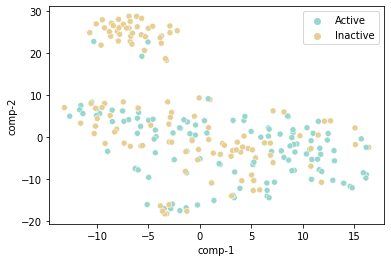

In [ ]:
# loading datasset
X_train_data_name = 'BBP_train_esm2_t6_8M_UR50D_unified_320_dimension.csv'
X_train_data = pd.read_csv(X_train_data_name,header=0, index_col = 0,delimiter=',')
X_test_data_name = 'BBP_test_esm2_t6_8M_UR50D_unified_320_dimension.csv'
X_test_data = pd.read_csv(X_test_data_name,header=0, index_col = 0,delimiter=',')
X_train = np.array(X_train_data)
X_test = np.array(X_test_data)
# training dataset loading
dataset = pd.read_excel('BBP_train.xlsx',na_filter = False) # take care the NA sequence problem
# loading the y dataset for model development 
y_train = dataset['label']
y_train = np.array(y_train) # transformed as np.array for CNN model
# training dataset loading
dataset = pd.read_excel('BBP_test.xlsx',na_filter = False) # take care the NA sequence problem
# loading the y dataset for model development 
y_test = dataset['label']
y_test = np.array(y_test) # transformed as np.array for CNN model
# normalize the X data range (just )
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train) # normalize X to 0-1 range 
X_test = scaler.transform(X_test)
# concatenate the dataset
X = np.concatenate((X_train, X_test), axis=0)
y = np.concatenate((y_train, y_test), axis=0)

from sklearn.manifold import TSNE
from keras.datasets import mnist
from sklearn.datasets import load_iris
from numpy import reshape
import seaborn as sns
import pandas as pd  
tsne = TSNE(n_components=2, verbose=0, perplexity= 25, learning_rate='auto',n_iter = 5000,random_state=123)
z = tsne.fit_transform(X) 
df = pd.DataFrame()
df["comp-1"] = z[:,0]
df["comp-2"] = z[:,1]
y_new_label=[]
for i in y:
    if i == 0:
        y_new_label.append('Active')
    if i == 1:
        y_new_label.append('Inactive')
df["y"] = y_new_label
graph = sns.scatterplot(data=df, x="comp-1", y="comp-2", hue=y_new_label,
                palette='BrBG_r', legend='full')
graph_for_output = graph.get_figure()
graph_for_output.savefig('11.BBP_t-SNE.png', dpi=300)
df.to_excel('11.BBP_t-SNE.xlsx')


In [1]:
!pip install umap

  Created wheel for umap: filename=umap-0.1.1-py3-none-any.whl size=3564 sha256=879a7899406d5aec8c819a383fa99940a5800f1e54e2ee1231bd20f2b57ac85c
  Stored in directory: /Users/zhenjiaodu/Library/Caches/pip/wheels/d4/13/91/2e752dc8dab5df027854bd33d2b65e1dc5cdc107fd1133990f
Successfully built umap


In [2]:
import umap
reducer = umap.UMAP()

AttributeError: module 'umap' has no attribute 'UMAP'